# Week 3: CNN Cancer Detection Kaggle Mini-Project

## 1. Introduction
This project aims to create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The dataset is retrieved from Kaggle: https://www.kaggle.com/competitions/histopathologic-cancer-detection/data. The dataset comprises a large number of small pathology images for classification, each identified by a unique ID. The train_labels.csv file provides the ground truth labels for the images in the training folder. The goal is to predict the labels for the images in the test folder. A positive identification indicates that the center 32x32 pixel region of a patch contains at least one pixel of tumor tissue.

## 2. Exploratory Data Analysis (EDA)
To begin with, I imported the necessary libraries, loaded the dataset, and defined directories. To gain a better understanding of my model, I split the data into two parts to train the model and test the accuracy of the model. After applying data augmentation and normalization, I visualized some sample images to gain a preliminary understanding of the data.

In [1]:
# Impport libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import os
from PIL import Image

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

# Load the train_labels CSV file
labels = pd.read_csv('train_labels.csv')
labels['id'] = labels['id'].apply(lambda x: x + '.tif')
labels['label'] = labels['label'].astype(str)
print(labels.head())

                                             id label
0  f38a6374c348f90b587e046aac6079959adf3835.tif     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif     1
2  755db6279dae599ebb4d39a9123cce439965282d.tif     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif     0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif     0


In [3]:
# Define directories
train_dir = 'train'
test_dir = 'test'

# Split the data into training and testing sets
train_labels, val_labels = train_test_split(labels, test_size=0.2, random_state=42)

In [4]:
# Data augmentation and normalization
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=train_dir,
    x_col='id',
    y_col='label',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='binary',
    target_size=(64, 64)
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_labels,
    directory=train_dir,
    x_col='id',
    y_col='label',
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode='binary',
    target_size=(64, 64)
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


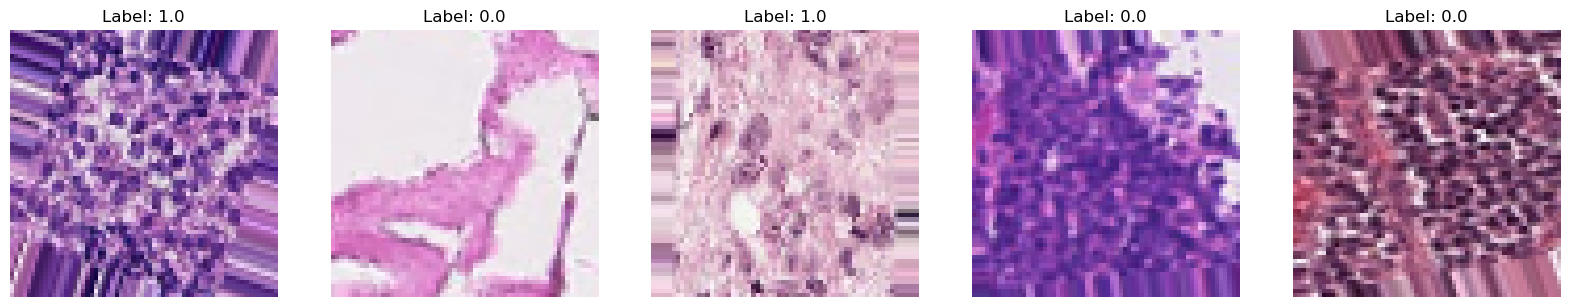

In [5]:
# Function to plot sample images
def plot_sample_images(generator):
    x, y = next(generator)
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    for i, ax in enumerate(axes):
        ax.imshow(x[i])
        ax.set_title(f"Label: {y[i]}")
        ax.axis('off')
    plt.show()

# Plot samples from training set
plot_sample_images(train_gen)

## 3. Model Building & Training
In this step, I built and trained a Convolutional Neural Network (CNN) to identify metastatic cancer in small image patches. Due to the large size of the training data, I limited the number of epochs to 5.

In [6]:
# Define the CNN model
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()

C:\Users\Cecile\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,329 (2.61 MB)

 Trainable params: 683,329 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

Epoch 1/5


C:\Users\Cecile\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 209s 38ms/step - accuracy: 0.7675 - loss: 0.4909 - val_accuracy: 0.8188 - val_loss: 0.3952
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 208s 38ms/step - accuracy: 0.8309 - loss: 0.3879 - val_accuracy: 0.8442 - val_loss: 0.3604
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 209s 38ms/step - accuracy: 0.8434 - loss: 0.3593 - val_accuracy: 0.8547 - val_loss: 0.3310
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 205s 37ms/step - accuracy: 0.8494 - loss: 0.3467 - val_accuracy: 0.8657 - val_loss: 0.3142
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 209s 38ms/step - accuracy: 0.8582 - loss: 0.3292 - val_accuracy: 0.8617 - val_loss: 0.3226


## 4. Model Evaluation
To evaluate the performance of the trained model, I used a confusion matrix and an ROC curve in this step.

In [8]:
# Evaluate model on validation set
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

# Get predictions on validation set
y_true = val_gen.classes
y_pred = model.predict(val_gen).ravel()
y_pred_binary = (y_pred > 0.5).astype(int)

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step - accuracy: 0.8619 - loss: 0.3158
Validation Loss: 0.3210771679878235
Validation Accuracy: 0.8596523404121399
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step


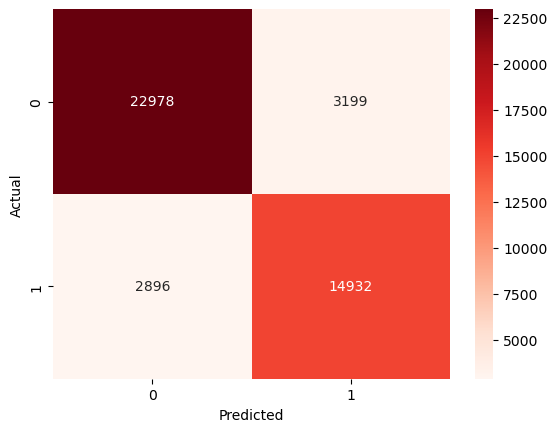

In [9]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d',cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

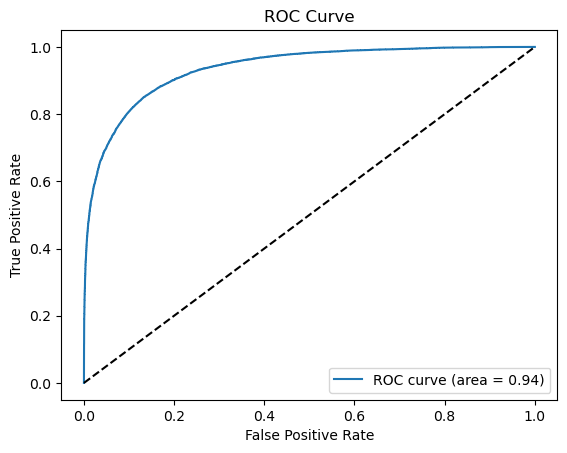

In [10]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 5. Generate Predictions for Test Folder

In [11]:
# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'id': os.listdir(test_dir)}),
    directory=test_dir,
    x_col='id',
    y_col=None,
    class_mode=None,
    target_size=(64, 64),
    batch_size=32,
    shuffle=False
)

# Generate predictions
test_gen.reset()
predictions = model.predict(test_gen)

# Convert predictions to binary labels
predicted_labels = (predictions > 0.5).astype(int)

# Create a DataFrame with the results
test_filenames = test_gen.filenames
results = pd.DataFrame({'id': test_filenames, 'label': predicted_labels.ravel()})

# Remove the '.tif' extension for submission
results['id'] = results['id'].str.replace('.tif', '')

# Save the results to a CSV file
results.to_csv('submission.csv', index=False)


Found 57458 validated image filenames.
   3/1796 ━━━━━━━━━━━━━━━━━━━━ 1:59 67ms/step

C:\Users\Cecile\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 203s 113ms/step


C:\Users\Cecile\AppData\Local\Temp\ipykernel_45552\48012961.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  results['id'] = results['id'].str.replace('.tif', '')


## 6. Conclusion
This project illustrated the process of developing a robust machine learning model for a critical healthcare application. The use of Convolutional Neural Networks (CNNs) proved effective for binary image classification in medical imaging. Future work could involve fine-tuning the model, increasing the number of training epochs, and exploring advanced techniques to further enhance accuracy and generalizability.